In [1]:
import math
import re
import time
import string
import pandas as pd
import numpy as np
import hdbscan
import logging
import faiss
from umap import UMAP
import networkx as nx
from collections import Counter
import jellyfish
from segtok.segmenter import split_multi
from segtok.tokenizer import web_tokenizer, split_contractions
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from fasttext import load_model


2022-08-04 13:02:58.595483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 13:02:58.595516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!free -gh

              total        used        free      shared  buff/cache   available
Mem:            62G        2.7G         52G        4.1M        7.5G         59G
Swap:            0B          0B          0B


In [3]:
STOPWORD_WEIGHT = 'bi'
class DataCore(object):
    
    def __init__(self, text, stopword_set, windowsSize, n, tagsToDiscard = set(['u', 'd']), exclude = set(string.punctuation)):
        self.number_of_sentences = 0
        self.number_of_words = 0
        self.terms = {}
        self.candidates = {}
        self.sentences_obj = []
        self.sentences_str = []
        self.G = nx.DiGraph()
        self.exclude = exclude
        self.tagsToDiscard = tagsToDiscard
        self.freq_ns = {}
        for i in range(n):
            self.freq_ns[i+1] = 0.
        self.stopword_set = stopword_set
        self._build(text, windowsSize, n)

    # Build the datacore features
    def _build(self, text, windowsSize, n):
        text = self.pre_filter(text)
        self.sentences_str = [ [w for w in split_contractions(web_tokenizer(s)) if not (w.startswith("'") and len(w) > 1) and len(w) > 0] for s in list(split_multi(text)) if len(s.strip()) > 0]
        self.number_of_sentences = len(self.sentences_str)
        pos_text = 0
        block_of_word_obj = []
        sentence_obj_aux = []
        for (sentence_id, sentence) in enumerate(self.sentences_str):
            sentence_obj_aux = []
            block_of_word_obj = []
            for (pos_sent, word) in enumerate(sentence):
                if len([c for c in word if c in self.exclude]) == len(word): # If the word is based on exclude chars
                    if len(block_of_word_obj) > 0:
                        sentence_obj_aux.append( block_of_word_obj )
                        block_of_word_obj = []
                else:
                    tag = self.getTag(word, pos_sent)
                    term_obj = self.getTerm(word)
                    term_obj.addOccur(tag, sentence_id, pos_sent, pos_text)
                    pos_text += 1

                    #Create co-occurrence matrix
                    if tag not in self.tagsToDiscard:
                        word_windows = list(range( max(0, len(block_of_word_obj)-windowsSize), len(block_of_word_obj) ))
                        for w in word_windows:
                            if block_of_word_obj[w][0] not in self.tagsToDiscard: 
                                self.addCooccur(block_of_word_obj[w][2], term_obj)
                    #Generate candidate keyphrase list
                    candidate = [ (tag, word, term_obj) ]
                    cand = composed_word(candidate)
                    self.addOrUpdateComposedWord(cand)
                    word_windows = list(range( max(0, len(block_of_word_obj)-(n-1)), len(block_of_word_obj) ))[::-1]
                    for w in word_windows:
                        candidate.append(block_of_word_obj[w])
                        self.freq_ns[len(candidate)] += 1.
                        cand = composed_word(candidate[::-1])
                        self.addOrUpdateComposedWord(cand)

                    # Add term to the block of words' buffer
                    block_of_word_obj.append( (tag, word, term_obj) )

            if len(block_of_word_obj) > 0:
                sentence_obj_aux.append( block_of_word_obj )

            if len(sentence_obj_aux) > 0:
                self.sentences_obj.append(sentence_obj_aux)

        if len(block_of_word_obj) > 0:
            sentence_obj_aux.append( block_of_word_obj )

        if len(sentence_obj_aux) > 0:
            self.sentences_obj.append(sentence_obj_aux)

        self.number_of_words = pos_text

    def build_single_terms_features(self, features=None):
        validTerms = [ term for term in self.terms.values() if not term.stopword ]
        validTFs = (np.array([ x.tf for x in validTerms ]))

        if len(validTFs) == 0:
            return

        avgTF = validTFs.mean()
        stdTF = validTFs.std()
        maxTF = max([ x.tf for x in self.terms.values()])
        list(map(lambda x: x.updateH(maxTF=maxTF, avgTF=avgTF, stdTF=stdTF, number_of_sentences=self.number_of_sentences, features=features), self.terms.values()))

    def build_mult_terms_features(self, features=None):
        list(map(lambda x: x.updateH(features=features), [cand for cand in self.candidates.values() if cand.isValid()]))

    def pre_filter(self, text):
        prog = re.compile("^(\\s*([A-Z]))")
        parts = text.split('\n')
        buffer = ''
        for part in parts:
            sep = ' '
            if prog.match(part):
                sep = '\n\n'
            buffer += sep + part.replace('\t',' ')
        return buffer

    def getTag(self, word, i):
        try:
            w2 = word.replace(",","")
            float(w2)
            return "d"
        except:
            cdigit = len([c for c in word if c.isdigit()])
            calpha = len([c for c in word if c.isalpha()])
            if ( cdigit > 0 and calpha > 0 ) or (cdigit == 0 and calpha == 0) or len([c for c in word if c in self.exclude]) > 1:
                return "u"
            if len(word) == len([c for c in word if c.isupper()]):
                return "a"
            if len([c for c in word if c.isupper()]) == 1 and len(word) > 1 and word[0].isupper() and i > 0:
                return "n"
        return "p"

    def getTerm(self, str_word, save_non_seen=True):
        unique_term = str_word.lower()
        simples_sto = unique_term in self.stopword_set
        if unique_term.endswith('s') and len(unique_term) > 3:
            unique_term = unique_term[:-1]

        if unique_term in self.terms:
            return self.terms[unique_term]
                
        # Include this part
        simples_unique_term = unique_term
        for pontuation in self.exclude:
            simples_unique_term = simples_unique_term.replace(pontuation, '')
        # until here
        isstopword = simples_sto or unique_term in self.stopword_set or len(simples_unique_term) < 3
        
        term_id = len(self.terms)
        term_obj = single_word(unique_term, term_id, self.G)
        term_obj.stopword = isstopword

        if save_non_seen:
            self.G.add_node(term_id)
            self.terms[unique_term] = term_obj

        return term_obj

    def addCooccur(self, left_term, right_term):
        if right_term.id not in self.G[left_term.id]:
            self.G.add_edge(left_term.id, right_term.id, TF=0.)
        self.G[left_term.id][right_term.id]["TF"]+=1.
        
    def addOrUpdateComposedWord(self, cand):
        if cand.unique_kw not in self.candidates:
            self.candidates[cand.unique_kw] = cand
        else:
            self.candidates[cand.unique_kw].uptadeCand(cand)
        self.candidates[cand.unique_kw].tf += 1.

In [4]:
class composed_word(object):
    def __init__(self, terms): # [ (tag, word, term_obj) ]
        if terms == None:
             self.start_or_end_stopwords = True
             self.tags = set()
             return
        self.tags = set([''.join([ w[0] for w in terms ])])
        self.kw = ' '.join( [ w[1] for w in terms ] )
        self.unique_kw = self.kw.lower()
        self.size = len(terms)
        self.terms = [ w[2] for w in terms if w[2] != None ]
        self.tf = 0.
        self.integrity = 1.
        self.H = 1.
        self.start_or_end_stopwords = self.terms[0].stopword or self.terms[-1].stopword

    def uptadeCand(self, cand):
        for tag in cand.tags:
            self.tags.add( tag )

    def isValid(self):
        isValid = False
        for tag in self.tags:
            isValid = isValid or ( "u" not in tag and "d" not in tag )
        return isValid and not self.start_or_end_stopwords

    def get_composed_feature(self, feature_name, discart_stopword=True):
        list_of_features = [ getattr(term, feature_name) for term in self.terms if ( discart_stopword and not term.stopword ) or not discart_stopword ]
        sum_f  = sum(list_of_features)
        prod_f = np.prod(list_of_features)
        return ( sum_f, prod_f, prod_f /(sum_f + 1) )

    def build_features(self, doc_id=None, keys=None, rel=True, rel_approx=True, isVirtual=False, features=['WFreq', 'WRel', 'tf', 'WCase', 'WPos', 'WSpread'], _stopword=[True, False]):
        columns = []
        seen = set()
        features_cand = []

        if doc_id != None:
            columns.append('doc_id')
            features_cand.append(doc_id)

        if keys != None:
            if rel:
                columns.append('rel')
                if self.unique_kw in keys or isVirtual:
                    features_cand.append(1)
                    seen.add(self.unique_kw)
                else:
                    features_cand.append(0)

            if rel_approx:
                columns.append('rel_approx')
                max_gold_ = ('', 0.)
                for gold_key in keys:
                    dist = 1.-jellyfish.levenshtein_distance(gold_key, self.unique_kw ) / max(len(gold_key), len(self.unique_kw)) # _tL
                    if max_gold_[1] < dist:
                        max_gold_ = ( gold_key, dist )
                features_cand.append(max_gold_[1])

        columns.append('kw')
        features_cand.append(self.unique_kw)
        columns.append('h')
        features_cand.append(self.H)
        columns.append('tf')
        features_cand.append(self.tf)
        columns.append('size')
        features_cand.append(self.size)
        columns.append('isVirtual')
        features_cand.append(int(isVirtual))

        for feature_name in features:

            for discart_stopword in _stopword:
                (f_sum, f_prod, f_sum_prod) = self.get_composed_feature(feature_name, discart_stopword=discart_stopword)
                columns.append('%ss_sum_K%s' % ('n' if discart_stopword else '', feature_name) )
                features_cand.append(f_sum)

                columns.append('%ss_prod_K%s' % ('n' if discart_stopword else '', feature_name) )
                features_cand.append(f_prod)

                columns.append('%ss_sum_prod_K%s' % ('n' if discart_stopword else '', feature_name) )
                features_cand.append(f_sum_prod)

        return (features_cand, columns, seen)

    def updateH(self, features=None, isVirtual=False):
        sum_H  = 0.
        prod_H = 1.

        for (t, term_base) in enumerate(self.terms):
            if not term_base.stopword:
                sum_H += term_base.H
                prod_H *= term_base.H

            else:
                if STOPWORD_WEIGHT == 'bi':
                    prob_t1 = 0.
                    if term_base.G.has_edge(self.terms[t-1].id, self.terms[ t ].id):
                        prob_t1 = term_base.G[self.terms[t-1].id][self.terms[ t ].id]["TF"] / self.terms[t-1].tf

                    prob_t2 = 0.
                    if term_base.G.has_edge(self.terms[ t ].id, self.terms[t+1].id):
                        prob_t2 = term_base.G[self.terms[ t ].id][self.terms[t+1].id]["TF"] / self.terms[t+1].tf

                    prob = prob_t1 * prob_t2
                    prod_H *= (1 + (1 - prob ) )
                    sum_H -= (1 - prob)
                elif STOPWORD_WEIGHT == 'h':
                    sum_H += term_base.H
                    prod_H *= term_base.H
                elif STOPWORD_WEIGHT == 'none':
                    pass

        tf_used = 1.
        if features == None or "KPF" in features:
            tf_used = self.tf

        if isVirtual:
            tf_used = np.mean( [term_obj.tf for term_obj in self.terms] )

        self.H = prod_H / ( ( sum_H + 1 ) * tf_used )

    def updateH_old(self, features=None, isVirtual=False):
        sum_H  = 0.
        prod_H = 1.

        for (t, term_base) in enumerate(self.terms):
            if isVirtual and term_base.tf==0:
                continue

            if term_base.stopword:
                prob_t1 = 0.
                if term_base.G.has_edge(self.terms[t-1].id, self.terms[ t ].id):
                    prob_t1 = term_base.G[self.terms[t-1].id][self.terms[ t ].id]["TF"] / self.terms[t-1].tf

                prob_t2 = 0.
                if term_base.G.has_edge(self.terms[ t ].id, self.terms[t+1].id):
                    prob_t2 = term_base.G[self.terms[ t ].id][self.terms[t+1].id]["TF"] / self.terms[t+1].tf

                prob = prob_t1 * prob_t2
                prod_H *= (1 + (1 - prob ) )
                sum_H -= (1 - prob)
            else:
                sum_H += term_base.H
                prod_H *= term_base.H
        tf_used = 1.
        if features == None or "KPF" in features:
            tf_used = self.tf
        if isVirtual:
            tf_used = np.mean( [term_obj.tf for term_obj in self.terms] )
        self.H = prod_H / ( ( sum_H + 1 ) * tf_used )

In [5]:
class single_word(object):

    def __init__(self, unique, idx, graph):
        self.unique_term = unique
        self.id = idx
        self.tf = 0.
        self.WFreq = 0.0
        self.WCase = 0.0
        self.tf_a = 0.
        self.tf_n = 0.
        self.WRel = 1.0
        self.PL = 0.
        self.PR = 0.
        self.occurs = {}
        self.WPos = 1.0
        self.WSpread = 0.0
        self.H = 0.0
        self.stopword = False
        self.G = graph

        self.pagerank = 1.

    def updateH(self, maxTF, avgTF, stdTF, number_of_sentences, features=None):
        """if features == None or "WRel" in features:
            self.PL = self.WDL / maxTF
            self.PR = self.WDR / maxTF
            self.WRel = ( (0.5 + (self.PWL * (self.tf / maxTF) + self.PL)) + (0.5 + (self.PWR * (self.tf / maxTF) + self.PR)) )"""

        if features == None or "WRel" in features:
            self.PL = self.WDL / maxTF
            self.PR = self.WDR / maxTF
            self.WRel = ( (0.5 + (self.PWL * (self.tf / maxTF))) + (0.5 + (self.PWR * (self.tf / maxTF))) )

        if features == None or "WFreq" in features:
            self.WFreq = self.tf / (avgTF + stdTF)
        
        if features == None or "WSpread" in features:
            self.WSpread = len(self.occurs) / number_of_sentences
        
        if features == None or "WCase" in features:
            self.WCase = max(self.tf_a, self.tf_n) / (1. + math.log(self.tf))
        
        if features == None or "WPos" in features:
            self.WPos = math.log( math.log( 3. + np.median(list(self.occurs.keys())) ) )

        self.H = (self.WPos * self.WRel) / (self.WCase + (self.WFreq / self.WRel) + (self.WSpread / self.WRel))
        
    @property
    def WDR(self):
        return len( self.G.out_edges(self.id) )

    @property
    def WIR(self):
        return sum( [ d['TF'] for (u,v,d) in self.G.out_edges(self.id, data=True) ] )

    @property
    def PWR(self):
        wir = self.WIR
        if wir == 0:
            return 0
        return self.WDR / wir 
    
    @property
    def WDL(self):
        return len( self.G.in_edges(self.id) )

    @property
    def WIL(self):
        return sum( [ d['TF'] for (u,v,d) in self.G.in_edges(self.id, data=True) ] )

    @property
    def PWL(self):
        wil = self.WIL
        if wil == 0:
            return 0
        return self.WDL / wil 

    def addOccur(self, tag, sent_id, pos_sent, pos_text):
        if sent_id not in self.occurs:
            self.occurs[sent_id] = []

        self.occurs[sent_id].append( (pos_sent, pos_text) )
        self.tf += 1.

        if tag == "a":
            self.tf_a += 1.
        if tag == "n":
            self.tf_n += 1.

In [58]:
class TopicsExtractor(object):
    def __init__(self, top=100, features=None, stopwords=None, nbrT=None,emb=None):
        self.stopword_set = set(stopwords)
        self.n = 1
        self.top = top
        self.dedupLim = 0.9
        self.features = features
        self.windowsSize = 10
        self.dedu_function = self.jaro
        self.nbrT = nbrT
        self.emb = emb
        fasttext_model = 'cc.ar.300.bin'#'cc.en.300.bin'#'wiki/wiki.fr.bin'
        self.model = load_model(fasttext_model)
        logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
        logging.info('model init')
    
    def txtPreprocessing(self, txt):
        _txtpp = []
        for s in txt:
            x = str(s)
            x = re.sub(r'http\S+', ' ', x)
            x = re.sub('[0-9]','',x)
            x = re.sub('<.*?>', ' ', x)
            x = re.sub(' +', ' ', x)
            x = re.sub("\[.*?\]"," ",x)
            x = re.sub("['\"\\n]"," ", x)
            x = re.sub("www.\S+"," ", x)
            x = re.sub('[{’{»|«}~}]', ' ',x)
            x = re.sub('\s+', ' ', x)
            x = re.sub("(.)\\1{2,}", "\\1", x)
            x = re.sub(' +', ' ',x)
            x = x.strip()
            _txtpp.append(x)
        return _txtpp
    
    def txtEmbedding(self, txt):
        txtVec =[]
        for s in txt:
            txtVec.append(self.model.get_sentence_vector(s))
        return np.array(txtVec)
#         ctxt = [" ".join([word for word in s.split(" ") if word not in self.stopword_set]) for s in txt]
#         documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(txt)]
#         doc2vec_args = {"vector_size": 500,
#                 "min_count": 55,
#                 "window": 10,
#                 "sample": 1e-5,
#                 "negative": 0,
#                 "hs": 1,
#                 "epochs": 50,
#                 "dm": 0,
#                 "dbow_words": 1,
#                 "workers":8,
#                "documents":documents}
#         model = Doc2Vec(**doc2vec_args)
#         return model.dv.get_normed_vectors()
    
    def faissClusters(self, embeddings, nbrT):
        kmeans = faiss.Kmeans(embeddings.shape[1], nbrT, niter=100, verbose=False)
        kmeans.train(embeddings)
        I =  kmeans.index.search(embeddings, 1)[1]
        return  I.reshape((I.shape[0],))

    
    def getClusers(self, embeddings):
        umap_model = UMAP(n_neighbors=50, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, verbose=False)
        if len(embeddings)//50000 < 2:
            _umap_embeddings = umap_model.fit_transform(embeddings)
            _embeddings = np.nan_to_num(_umap_embeddings) 
        else:
            umap_model.fit(embeddings[np.random.choice(embeddings.shape[0], 60000, replace=False), :])
            chunks = np.array_split(embeddings, len(embeddings)//50000)
            _umap_embeddings = []
            for chunk in chunks:
                _umap_embeddings.extend(umap_model.transform(chunk))
            _embeddings = np.nan_to_num(_umap_embeddings)  

        hdbscan_model =hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean',cluster_selection_method='eom', prediction_data=True)
        hdbscan_model.fit(_embeddings)
        return hdbscan_model.labels_

    
#     def getClusers(self, embeddings):
#         outliers = len(embeddings)*.22
#         min_cluster_size, min_samples = 20, 2
#         clusters = np.full(embeddings.shape[0], -1)
#         _clusters = np.arange(len(clusters))

#         umap_model = UMAP(n_neighbors=50, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, verbose=False)
#         if len(embeddings)//50000 < 2:
#             _umap_embeddings = umap_model.fit_transform(embeddings)
#             _embeddings = np.nan_to_num(_umap_embeddings) 
#         else:
#             umap_model.fit(embeddings[np.random.choice(embeddings.shape[0], 60000, replace=False), :])
#             chunks = np.array_split(embeddings, len(embeddings)//50000)
#             _umap_embeddings = []
#             for chunk in chunks:
#                 _umap_embeddings.extend(umap_model.transform(chunk))
#             _embeddings = np.nan_to_num(_umap_embeddings)    
#         while(len(_clusters)>outliers):
#             nbrCl = len(set(clusters))-1
#             hdbscan_model =hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean',cluster_selection_method='eom', prediction_data=True)
#             hdbscan_model.fit(_embeddings)
#             indexes = np.argwhere(hdbscan_model.labels_!=-1)
#             for i, v in zip(indexes, hdbscan_model.labels_[indexes]):
#                 clusters[_clusters[i]] = nbrCl + v
#             _clusters = np.argwhere(hdbscan_model.labels_==-1)
#             _embeddings = _embeddings[_clusters]
#             if _embeddings.size == 0: break
#             _embeddings = _embeddings.reshape(len(_clusters),-1)
#             min_cluster_size, min_samples = 10, 2
#         return clusters

    def getFreqKeywords(self,doc):
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=self.stopword_set)
        tfidf = tfidf_vectorizer.fit_transform([doc])
        score = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
        candidates = np.array(tfidf_vectorizer.get_feature_names())[score[:np.minimum(450,len(score)-1)]]
        return ' '.join(candidates)

    def jaro(self, cand1, cand2):
        return jellyfish.jaro_winkler(cand1, cand2 )

    def extract_keywords(self, text):
        try:
            if not(len(text) > 0):
                return []
            
            text = text.replace('\n\t',' ')
            dc = DataCore(text=text, stopword_set=self.stopword_set, windowsSize=self.windowsSize, n=self.n)
            dc.build_single_terms_features(features=self.features)
            dc.build_mult_terms_features(features=self.features)
            resultSet = []
            todedup = sorted([cc for cc in dc.candidates.values() if cc.isValid()], key=lambda c: c.H)

            if self.dedupLim >= 1.:
                return ([ (cand.H, cand.unique_kw) for cand in todedup])[:self.top]

            for cand in todedup:
                toadd = True
                for (h, candResult) in resultSet:
                    dist = self.dedu_function(cand.unique_kw, candResult.unique_kw)
                    if dist > self.dedupLim:
                        toadd = False
                        break
                if toadd:
                    resultSet.append( (cand.H, cand) )
                if len(resultSet) == self.top:
                    break

            return [cand.kw for (h,cand) in resultSet]
        except Exception as e:
            print(f"Warning! Exception: {e} generated by the following text: '{text}' ")
            return []
    
    def groupBy(self, txtpp, clusters, nbrClusters):
        docs ={}
        for cluster, txt in zip(clusters,txtpp):
            if cluster in docs:
                docs[cluster] += " . "+txt
            else:
                docs[cluster] = txt
        docs.pop(-1)
        docs = dict(sorted(docs.items()))
        data = list(docs.values())
        return np.array(data)
    
    def extract_topics_keywords(self, docs):
        topics = []
        for doc in docs:
            topics.append(self.extract_keywords(doc))
        return topics

    def clusterreduction(self, docs, nbrClusters, clusters):
        freqKey = []
        embeddings = []
        for doc in docs[1:]: freqKey.append(self.getFreqKeywords(doc))
        for doc in freqKey:embeddings.append(self.model.get_sentence_vector(doc))
        hdbscan_model =hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
        hdbscan_model.fit(embeddings)
        print(hdbscan_model.labels_, set(hdbscan_model.labels_))
        mapper = []
        for i, lable in enumerate(hdbscan_model.labels_):
            if lable !=-1:
                mapper.append(nbrClusters + lable)
            else:
                mapper.append(i + 1)
        _args = np.array(sorted(mapper))
        
        for i, lable in enumerate(mapper): 
            mapper[i]=np.argwhere(lable == _args)[0].item()
        topicMapper = {}
        
        for o,n in zip(docs[1:],mapper): 
            topicMapper[o] = n 
        for i, v in enumerate(clusters):
            try:
                clusters[i]= topicMapper[v]
            except: pass
        return clusters
   
    def score(self, docs):
        wordLists = []
        scoreLists = []
        for doc in docs:
            fidf_vectorizer = TfidfVectorizer(stop_words=self.stopword_set)
            tfidf = fidf_vectorizer.fit_transform([doc])
            importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
            tfidf_feature_names = np.array(fidf_vectorizer.get_feature_names())
            wordLists.append(tfidf_feature_names[importance[:150]])
        return np.array(wordLists)
    
    def selectTopicWords(self, wf, keywords):
        topics = []
        for w, k in zip(wf,keywords):
            intersect = np.intersect1d(w, k)
            nkp = []
            for i in intersect:
                nkp.append(np.argwhere(w==i).item())
            topic = []
            for i in sorted(list(zip(nkp,intersect))):
                topic.append(i[1])
                if i[0]==20:
                    break
            topics.append(topic)

        return topics
                    
    def keyfilter(self, key, n=4):
        topics = []
        try:
            _key = key.reshape((key.shape[1]*key.shape[0],))
        except:
            m = np.array([len(i) for i in key]).min()
            print(m)
            key = np.array([i[:m] for i in key])
            _key = key.reshape((key.shape[1]*key.shape[0],))
        cc = sorted(Counter(_key).items(),reverse=True, key=lambda kv: kv[1])
        _w, _s = zip(*cc)
        w = np.array(_w)[np.argwhere(np.array(_s)>n)]
        _w = []
        for i in w:
            _wp = []
            for j in key:
                try:
                    _wp.append(np.argwhere(i==np.array(j))[0].item())
                except:
                    _wp.append(9999999999)
            _w.append(np.array(_wp).argmin())
        _w = np.array(_wp)
#         print(len(w))
        for t, ks in enumerate(key):
            inter = np.intersect1d(ks,w)
            try:
                inter = np.setdiff1d(inter,w[np.argwhere(t==_w)])
#                 print('done will!')
            except: pass
            ks = ks[np.in1d(ks,np.setdiff1d(ks,inter))]
            topics.append(list(ks[:25]))
        return topics

    def extract_topics(self, text):
        txtpp = self.txtPreprocessing(text)
        logging.info('end of text pre processing')
        if self.emb is None: embeddings = self.txtEmbedding(txtpp)
        else:embeddings = self.emb
        logging.info('end of text embedding')
        if isinstance(self.nbrT, int): clusters = self.faissClusters(embeddings,self.nbrT)
        else:clusters = self.getClusers(embeddings)
        nbrClusters = len(set(clusters))
        logging.info(f'end of clustring : {nbrClusters}')
        docs = self.groupBy(txtpp, clusters, nbrClusters)
        keywords = self.extract_topics_keywords(docs)
        logging.info('end of key extra')
        topics = self.keyfilter(np.array(keywords))
        return topics, clusters,keywords

In [41]:
with open('./20nw.npy', 'rb') as f:
    emb = np.load(f)

In [278]:
data = pd.read_csv('/data/notebooks/others/french_tweets.csv')

In [9]:
data = pd.read_parquet('/data/big-data-collection/OTHERS/data_esg.parquet')
data = data[['TITRE','CONTENU']]
data["txt"] = data['TITRE'] +" "+data['CONTENU']

In [669]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
text = newsgroups_train.data

In [36]:
stopWords = open('./stopwordAr', 'r').readlines()
for i in range(len(stopWords)):
    stopWords[i] = stopWords[i].replace('\n', '').replace(' ', '')
stopWords += list(set(stopWords))

In [57]:
from octis.dataset.dataset import Dataset
dataset = Dataset()
dataset.fetch_dataset("20NewsGroup")#BBC_News

data = dataset.get_corpus()
data = [" ".join(words) for words in data]

In [96]:
data.head()

,TITRE,CONTENU,txt
0,"L’Afrique doit rompre avec la ""subordination c...","\n\t\n\t\tDakar, 14 mars (APS) – Le professeur...","L’Afrique doit rompre avec la ""subordination c..."
1,"L’Afrique doit rompre avec la ""subordination c...","\n\t\n\t\tDakar, 14 mars (APS) – Le professeur...","L’Afrique doit rompre avec la ""subordination c..."
2,Kébemer : une marche contre les violences dont...,"\n\t\n\t\tKébémer, 31 mai (APS) - Une marche d...",Kébemer : une marche contre les violences dont...
3,Kébemer : une marche contre les violences dont...,"\n\t\n\t\tKébémer, 31 mai (APS) - Une marche d...",Kébemer : une marche contre les violences dont...
4,Vers un dispositif fonctionnel de recueil des ...,"\n\tDakar, 11 juin (APS) – Le ministère de la ...",Vers un dispositif fonctionnel de recueil des ...


In [14]:
d = {-1:56, 2: 2, 55: 2, 7: 2}
d.pop(-1)
d

{2: 2, 55: 2, 7: 2}

In [87]:
topicModel = TopicsExtractor(top=50, stopwords=stopWords)
out = topicModel.extract_topics(txt)

2022-08-04 13:55:50,368 - model init
2022-08-04 13:56:09,243 - end of text pre processing
2022-08-04 13:56:47,355 - end of text embedding
2022-08-04 14:28:58,832 - end of clustring : 101
2022-08-04 15:05:33,996 - end of key extra


9


/tmp/ipykernel_13015/1312901169.py:274: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  topics = self.keyfilter(np.array(keywords))


In [81]:
alout = []
for i in range(10,51,10):
    topicModel = TopicsExtractor(top=20, stopwords=stopWords,nbrT=i)
    alout.append(topicModel.extract_topics(data)[0])

2022-08-01 17:36:40,733 - model init
2022-08-01 17:36:41,651 - end of text pre processing
2022-08-01 17:36:43,522 - end of text embedding
2022-08-01 17:36:53,761 - end of clustring : 10
2022-08-01 17:38:05,842 - end of key extra
2022-08-01 17:38:09,499 - model init
2022-08-01 17:38:10,450 - end of text pre processing
2022-08-01 17:38:12,364 - end of text embedding
2022-08-01 17:38:25,959 - end of clustring : 20
2022-08-01 17:39:43,306 - end of key extra
/tmp/ipykernel_27089/4263313410.py:262: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  topics = self.keyfilter(np.array(keywords))


5


2022-08-01 17:39:46,590 - model init
2022-08-01 17:39:47,527 - end of text pre processing
2022-08-01 17:39:49,400 - end of text embedding
2022-08-01 17:40:03,032 - end of clustring : 30
2022-08-01 17:41:21,638 - end of key extra


4


2022-08-01 17:41:25,242 - model init
2022-08-01 17:41:26,188 - end of text pre processing
2022-08-01 17:41:28,036 - end of text embedding
2022-08-01 17:41:44,907 - end of clustring : 40
2022-08-01 17:43:06,664 - end of key extra


5


2022-08-01 17:43:09,923 - model init
2022-08-01 17:43:10,866 - end of text pre processing
2022-08-01 17:43:12,767 - end of text embedding
2022-08-01 17:43:33,227 - end of clustring : 50
2022-08-01 17:44:54,970 - end of key extra


4


In [60]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

In [62]:
output_tm = {
            "topics": out[2],
        }
metric = TopicDiversity(topk=5) # Initialize metric
topic_diversity_score = metric.score(output_tm)
topic_diversity_score

0.671875

In [68]:
nemb = nemb.reshape((nemb.shape[0],nemb.shape[2]))

In [69]:
hdbscan_model =hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model.fit(nemb)
print(hdbscan_model.labels_, set(hdbscan_model.labels_))

[ 0 -1  0 ...  0 -1  0] {0, 1, -1}


In [77]:
m = np.array([len(i) for i in np.array(out[2])]).min()
nl = np.array([i[:m] for i in np.array(out[2])])

/tmp/ipykernel_27089/2894907307.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = np.array([len(i) for i in np.array(out[2])]).min()
/tmp/ipykernel_27089/2894907307.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nl = np.array([i[:m] for i in np.array(out[2])])


In [ ]:
from sklearn.metrics import silhouette_score

In [71]:
pd.DataFrame(hdbscan_model.labels_).value_counts()

 0    11006
-1     3718
 1        3
dtype: int64

In [53]:
hdbscan_model =hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model.fit(emb)
print(hdbscan_model.labels_, set(hdbscan_model.labels_))

[-1 -1 -1 ... -1 -1 -1] {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, -1}


In [75]:
nemb.shape

(14727, 768)

In [76]:
Ds = []
Is = []
for i in range(2,25,1):
    kmeans = faiss.Kmeans(nemb.shape[1], i, niter=20, verbose=False)
    kmeans.train(nemb)
    D, I =  kmeans.index.search(nemb, 1)
    Ds.append(D.mean())
    Is.append(I)
    
    # I.reshape((I.shape[0],))

In [31]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.metrics import silhouette_score


In [77]:
sc = []
for i in Is:
    sc.append(silhouette_score(nemb, i, metric='euclidean'))

/data/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/data/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/data/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/data/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

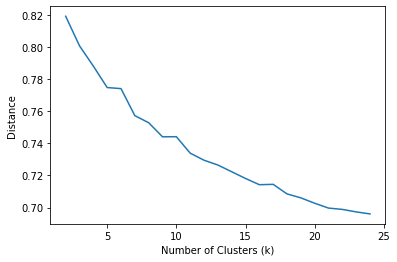

In [78]:
plt.plot(np.arange(2,25,1),Ds)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

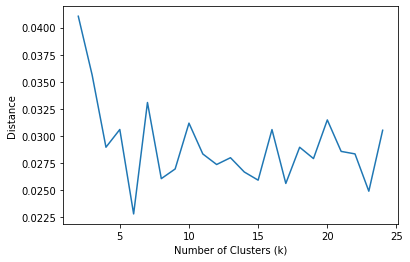

In [79]:
plt.plot(np.arange(2,25,1), sc)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

In [54]:
docs = {-1:55,1:88,3:55,9:48,-2:66}
# sorted(docs)
data = list(docs.values())
np.array(data)

array([66, 55, 88, 55, 48])

In [53]:
dict(sorted(docs.items()))

{-2: 66, -1: 55, 1: 88, 3: 55, 9: 48}

In [1449]:
from octis.evaluation_metrics.coherence_metrics import Coherence
npmi = Coherence(texts=dataset.get_corpus(), topk=5, measure="c_npmi")
score = npmi.score(output_tm)

2022-08-01 15:46:37,931 - adding document #0 to Dictionary<0 unique tokens: []>
2022-08-01 15:46:38,264 - adding document #10000 to Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...>
2022-08-01 15:46:38,474 - built Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...> from 16309 documents (total 783151 corpus positions)
2022-08-01 15:46:38,474 - Dictionary lifecycle event {'msg': "built Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...> from 16309 documents (total 783151 corpus positions)", 'datetime': '2022-08-01T15:46:38.474781', 'gensim': '4.2.0', 'python': '3.8.0 (default, Dec  9 2021, 17:53:27) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-1080-azure-x86_64-with-glibc2.27', 'event': 'created'}
2022-08-01 15:46:38,493 - using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2022-08-01 15:46:38,500 - WordOccurrenceAccumulator accumulated stats from 1000 documents
2022-08-01 15:46:38,508 - Word

2022-08-01 15:46:39,091 - WordOccurrenceAccumulator accumulated stats from 82000 documents
2022-08-01 15:46:39,099 - WordOccurrenceAccumulator accumulated stats from 83000 documents
2022-08-01 15:46:39,105 - WordOccurrenceAccumulator accumulated stats from 84000 documents
2022-08-01 15:46:39,114 - WordOccurrenceAccumulator accumulated stats from 85000 documents
2022-08-01 15:46:39,122 - WordOccurrenceAccumulator accumulated stats from 86000 documents
2022-08-01 15:46:39,130 - WordOccurrenceAccumulator accumulated stats from 87000 documents
2022-08-01 15:46:39,138 - WordOccurrenceAccumulator accumulated stats from 88000 documents
2022-08-01 15:46:39,145 - WordOccurrenceAccumulator accumulated stats from 89000 documents
2022-08-01 15:46:39,151 - WordOccurrenceAccumulator accumulated stats from 90000 documents
2022-08-01 15:46:39,157 - WordOccurrenceAccumulator accumulated stats from 91000 documents
2022-08-01 15:46:39,166 - WordOccurrenceAccumulator accumulated stats from 92000 documents

2022-08-01 15:46:39,750 - WordOccurrenceAccumulator accumulated stats from 172000 documents
2022-08-01 15:46:39,757 - WordOccurrenceAccumulator accumulated stats from 173000 documents
2022-08-01 15:46:39,765 - WordOccurrenceAccumulator accumulated stats from 174000 documents
2022-08-01 15:46:39,774 - WordOccurrenceAccumulator accumulated stats from 175000 documents
2022-08-01 15:46:39,781 - WordOccurrenceAccumulator accumulated stats from 176000 documents
2022-08-01 15:46:39,788 - WordOccurrenceAccumulator accumulated stats from 177000 documents
2022-08-01 15:46:39,795 - WordOccurrenceAccumulator accumulated stats from 178000 documents
2022-08-01 15:46:39,801 - WordOccurrenceAccumulator accumulated stats from 179000 documents
2022-08-01 15:46:39,807 - WordOccurrenceAccumulator accumulated stats from 180000 documents
2022-08-01 15:46:39,815 - WordOccurrenceAccumulator accumulated stats from 181000 documents
2022-08-01 15:46:39,823 - WordOccurrenceAccumulator accumulated stats from 18200

2022-08-01 15:46:40,400 - WordOccurrenceAccumulator accumulated stats from 262000 documents
2022-08-01 15:46:40,407 - WordOccurrenceAccumulator accumulated stats from 263000 documents
2022-08-01 15:46:40,414 - WordOccurrenceAccumulator accumulated stats from 264000 documents
2022-08-01 15:46:40,419 - WordOccurrenceAccumulator accumulated stats from 265000 documents
2022-08-01 15:46:40,425 - WordOccurrenceAccumulator accumulated stats from 266000 documents
2022-08-01 15:46:40,433 - WordOccurrenceAccumulator accumulated stats from 267000 documents
2022-08-01 15:46:40,440 - WordOccurrenceAccumulator accumulated stats from 268000 documents
2022-08-01 15:46:40,449 - WordOccurrenceAccumulator accumulated stats from 269000 documents
2022-08-01 15:46:40,456 - WordOccurrenceAccumulator accumulated stats from 270000 documents
2022-08-01 15:46:40,464 - WordOccurrenceAccumulator accumulated stats from 271000 documents
2022-08-01 15:46:40,471 - WordOccurrenceAccumulator accumulated stats from 27200

2022-08-01 15:46:41,082 - WordOccurrenceAccumulator accumulated stats from 352000 documents
2022-08-01 15:46:41,090 - WordOccurrenceAccumulator accumulated stats from 353000 documents
2022-08-01 15:46:41,099 - WordOccurrenceAccumulator accumulated stats from 354000 documents
2022-08-01 15:46:41,107 - WordOccurrenceAccumulator accumulated stats from 355000 documents
2022-08-01 15:46:41,114 - WordOccurrenceAccumulator accumulated stats from 356000 documents
2022-08-01 15:46:41,122 - WordOccurrenceAccumulator accumulated stats from 357000 documents
2022-08-01 15:46:41,130 - WordOccurrenceAccumulator accumulated stats from 358000 documents
2022-08-01 15:46:41,139 - WordOccurrenceAccumulator accumulated stats from 359000 documents
2022-08-01 15:46:41,146 - WordOccurrenceAccumulator accumulated stats from 360000 documents
2022-08-01 15:46:41,154 - WordOccurrenceAccumulator accumulated stats from 361000 documents
2022-08-01 15:46:41,162 - WordOccurrenceAccumulator accumulated stats from 36200

2022-08-01 15:46:41,783 - WordOccurrenceAccumulator accumulated stats from 442000 documents
2022-08-01 15:46:41,790 - WordOccurrenceAccumulator accumulated stats from 443000 documents
2022-08-01 15:46:41,798 - WordOccurrenceAccumulator accumulated stats from 444000 documents
2022-08-01 15:46:41,806 - WordOccurrenceAccumulator accumulated stats from 445000 documents
2022-08-01 15:46:41,814 - WordOccurrenceAccumulator accumulated stats from 446000 documents
2022-08-01 15:46:41,822 - WordOccurrenceAccumulator accumulated stats from 447000 documents
2022-08-01 15:46:41,831 - WordOccurrenceAccumulator accumulated stats from 448000 documents
2022-08-01 15:46:41,838 - WordOccurrenceAccumulator accumulated stats from 449000 documents
2022-08-01 15:46:41,845 - WordOccurrenceAccumulator accumulated stats from 450000 documents
2022-08-01 15:46:41,853 - WordOccurrenceAccumulator accumulated stats from 451000 documents
2022-08-01 15:46:41,861 - WordOccurrenceAccumulator accumulated stats from 45200

2022-08-01 15:46:42,504 - WordOccurrenceAccumulator accumulated stats from 532000 documents
2022-08-01 15:46:42,512 - WordOccurrenceAccumulator accumulated stats from 533000 documents
2022-08-01 15:46:42,520 - WordOccurrenceAccumulator accumulated stats from 534000 documents
2022-08-01 15:46:42,529 - WordOccurrenceAccumulator accumulated stats from 535000 documents
2022-08-01 15:46:42,535 - WordOccurrenceAccumulator accumulated stats from 536000 documents
2022-08-01 15:46:42,542 - WordOccurrenceAccumulator accumulated stats from 537000 documents
2022-08-01 15:46:42,551 - WordOccurrenceAccumulator accumulated stats from 538000 documents
2022-08-01 15:46:42,558 - WordOccurrenceAccumulator accumulated stats from 539000 documents
2022-08-01 15:46:42,565 - WordOccurrenceAccumulator accumulated stats from 540000 documents
2022-08-01 15:46:42,573 - WordOccurrenceAccumulator accumulated stats from 541000 documents
2022-08-01 15:46:42,581 - WordOccurrenceAccumulator accumulated stats from 54200

2022-08-01 15:46:43,133 - WordOccurrenceAccumulator accumulated stats from 622000 documents
2022-08-01 15:46:43,141 - WordOccurrenceAccumulator accumulated stats from 623000 documents
2022-08-01 15:46:43,146 - WordOccurrenceAccumulator accumulated stats from 624000 documents
2022-08-01 15:46:43,153 - WordOccurrenceAccumulator accumulated stats from 625000 documents
2022-08-01 15:46:43,161 - WordOccurrenceAccumulator accumulated stats from 626000 documents
2022-08-01 15:46:43,168 - WordOccurrenceAccumulator accumulated stats from 627000 documents
2022-08-01 15:46:43,174 - WordOccurrenceAccumulator accumulated stats from 628000 documents
2022-08-01 15:46:43,178 - WordOccurrenceAccumulator accumulated stats from 629000 documents
2022-08-01 15:46:43,182 - WordOccurrenceAccumulator accumulated stats from 630000 documents
2022-08-01 15:46:43,186 - WordOccurrenceAccumulator accumulated stats from 631000 documents
2022-08-01 15:46:43,193 - WordOccurrenceAccumulator accumulated stats from 63200

In [1414]:
lll =[]
for i in alout[0]:
    lll.extend(i)

In [1416]:
len(set(lll))

160

In [88]:
td = []
tc = []
for o in alout:
    output_tm = {"topics": o,}
    metric = TopicDiversity(topk=4) # Initialize metric
    td.append(metric.score(output_tm))
    npmi = Coherence(texts=dataset.get_corpus(), topk=4, measure="c_npmi")
    tc.append(npmi.score(output_tm))

2022-08-01 17:46:20,200 - adding document #0 to Dictionary<0 unique tokens: []>
2022-08-01 17:46:20,497 - adding document #10000 to Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...>
2022-08-01 17:46:20,689 - built Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...> from 16309 documents (total 783151 corpus positions)
2022-08-01 17:46:20,690 - Dictionary lifecycle event {'msg': "built Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...> from 16309 documents (total 783151 corpus positions)", 'datetime': '2022-08-01T17:46:20.690087', 'gensim': '4.2.0', 'python': '3.8.0 (default, Dec  9 2021, 17:53:27) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-1080-azure-x86_64-with-glibc2.27', 'event': 'created'}
2022-08-01 17:46:20,691 - using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2022-08-01 17:46:20,699 - WordOccurrenceAccumulator accumulated stats from 1000 documents
2022-08-01 17:46:20,706 - Word

2022-08-01 17:46:21,292 - WordOccurrenceAccumulator accumulated stats from 82000 documents
2022-08-01 17:46:21,300 - WordOccurrenceAccumulator accumulated stats from 83000 documents
2022-08-01 17:46:21,307 - WordOccurrenceAccumulator accumulated stats from 84000 documents
2022-08-01 17:46:21,316 - WordOccurrenceAccumulator accumulated stats from 85000 documents
2022-08-01 17:46:21,324 - WordOccurrenceAccumulator accumulated stats from 86000 documents
2022-08-01 17:46:21,332 - WordOccurrenceAccumulator accumulated stats from 87000 documents
2022-08-01 17:46:21,340 - WordOccurrenceAccumulator accumulated stats from 88000 documents
2022-08-01 17:46:21,347 - WordOccurrenceAccumulator accumulated stats from 89000 documents
2022-08-01 17:46:21,354 - WordOccurrenceAccumulator accumulated stats from 90000 documents
2022-08-01 17:46:21,361 - WordOccurrenceAccumulator accumulated stats from 91000 documents
2022-08-01 17:46:21,369 - WordOccurrenceAccumulator accumulated stats from 92000 documents

2022-08-01 17:46:21,961 - WordOccurrenceAccumulator accumulated stats from 172000 documents
2022-08-01 17:46:21,969 - WordOccurrenceAccumulator accumulated stats from 173000 documents
2022-08-01 17:46:21,976 - WordOccurrenceAccumulator accumulated stats from 174000 documents
2022-08-01 17:46:21,984 - WordOccurrenceAccumulator accumulated stats from 175000 documents
2022-08-01 17:46:21,992 - WordOccurrenceAccumulator accumulated stats from 176000 documents
2022-08-01 17:46:21,999 - WordOccurrenceAccumulator accumulated stats from 177000 documents
2022-08-01 17:46:22,005 - WordOccurrenceAccumulator accumulated stats from 178000 documents
2022-08-01 17:46:22,012 - WordOccurrenceAccumulator accumulated stats from 179000 documents
2022-08-01 17:46:22,018 - WordOccurrenceAccumulator accumulated stats from 180000 documents
2022-08-01 17:46:22,026 - WordOccurrenceAccumulator accumulated stats from 181000 documents
2022-08-01 17:46:22,033 - WordOccurrenceAccumulator accumulated stats from 18200

2022-08-01 17:46:22,611 - WordOccurrenceAccumulator accumulated stats from 262000 documents
2022-08-01 17:46:22,617 - WordOccurrenceAccumulator accumulated stats from 263000 documents
2022-08-01 17:46:22,624 - WordOccurrenceAccumulator accumulated stats from 264000 documents
2022-08-01 17:46:22,629 - WordOccurrenceAccumulator accumulated stats from 265000 documents
2022-08-01 17:46:22,636 - WordOccurrenceAccumulator accumulated stats from 266000 documents
2022-08-01 17:46:22,643 - WordOccurrenceAccumulator accumulated stats from 267000 documents
2022-08-01 17:46:22,651 - WordOccurrenceAccumulator accumulated stats from 268000 documents
2022-08-01 17:46:22,658 - WordOccurrenceAccumulator accumulated stats from 269000 documents
2022-08-01 17:46:22,665 - WordOccurrenceAccumulator accumulated stats from 270000 documents
2022-08-01 17:46:22,673 - WordOccurrenceAccumulator accumulated stats from 271000 documents
2022-08-01 17:46:22,679 - WordOccurrenceAccumulator accumulated stats from 27200

2022-08-01 17:46:23,252 - WordOccurrenceAccumulator accumulated stats from 352000 documents
2022-08-01 17:46:23,261 - WordOccurrenceAccumulator accumulated stats from 353000 documents
2022-08-01 17:46:23,268 - WordOccurrenceAccumulator accumulated stats from 354000 documents
2022-08-01 17:46:23,275 - WordOccurrenceAccumulator accumulated stats from 355000 documents
2022-08-01 17:46:23,282 - WordOccurrenceAccumulator accumulated stats from 356000 documents
2022-08-01 17:46:23,290 - WordOccurrenceAccumulator accumulated stats from 357000 documents
2022-08-01 17:46:23,297 - WordOccurrenceAccumulator accumulated stats from 358000 documents
2022-08-01 17:46:23,306 - WordOccurrenceAccumulator accumulated stats from 359000 documents
2022-08-01 17:46:23,313 - WordOccurrenceAccumulator accumulated stats from 360000 documents
2022-08-01 17:46:23,321 - WordOccurrenceAccumulator accumulated stats from 361000 documents
2022-08-01 17:46:23,328 - WordOccurrenceAccumulator accumulated stats from 36200

2022-08-01 17:46:23,903 - WordOccurrenceAccumulator accumulated stats from 442000 documents
2022-08-01 17:46:23,910 - WordOccurrenceAccumulator accumulated stats from 443000 documents
2022-08-01 17:46:23,918 - WordOccurrenceAccumulator accumulated stats from 444000 documents
2022-08-01 17:46:23,925 - WordOccurrenceAccumulator accumulated stats from 445000 documents
2022-08-01 17:46:23,934 - WordOccurrenceAccumulator accumulated stats from 446000 documents
2022-08-01 17:46:23,941 - WordOccurrenceAccumulator accumulated stats from 447000 documents
2022-08-01 17:46:23,949 - WordOccurrenceAccumulator accumulated stats from 448000 documents
2022-08-01 17:46:23,957 - WordOccurrenceAccumulator accumulated stats from 449000 documents
2022-08-01 17:46:23,963 - WordOccurrenceAccumulator accumulated stats from 450000 documents
2022-08-01 17:46:23,971 - WordOccurrenceAccumulator accumulated stats from 451000 documents
2022-08-01 17:46:23,978 - WordOccurrenceAccumulator accumulated stats from 45200

2022-08-01 17:46:24,570 - WordOccurrenceAccumulator accumulated stats from 532000 documents
2022-08-01 17:46:24,577 - WordOccurrenceAccumulator accumulated stats from 533000 documents
2022-08-01 17:46:24,584 - WordOccurrenceAccumulator accumulated stats from 534000 documents
2022-08-01 17:46:24,592 - WordOccurrenceAccumulator accumulated stats from 535000 documents
2022-08-01 17:46:24,598 - WordOccurrenceAccumulator accumulated stats from 536000 documents
2022-08-01 17:46:24,606 - WordOccurrenceAccumulator accumulated stats from 537000 documents
2022-08-01 17:46:24,614 - WordOccurrenceAccumulator accumulated stats from 538000 documents
2022-08-01 17:46:24,622 - WordOccurrenceAccumulator accumulated stats from 539000 documents
2022-08-01 17:46:24,630 - WordOccurrenceAccumulator accumulated stats from 540000 documents
2022-08-01 17:46:24,637 - WordOccurrenceAccumulator accumulated stats from 541000 documents
2022-08-01 17:46:24,645 - WordOccurrenceAccumulator accumulated stats from 54200

2022-08-01 17:46:25,228 - WordOccurrenceAccumulator accumulated stats from 622000 documents
2022-08-01 17:46:25,235 - WordOccurrenceAccumulator accumulated stats from 623000 documents
2022-08-01 17:46:25,241 - WordOccurrenceAccumulator accumulated stats from 624000 documents
2022-08-01 17:46:25,249 - WordOccurrenceAccumulator accumulated stats from 625000 documents
2022-08-01 17:46:25,256 - WordOccurrenceAccumulator accumulated stats from 626000 documents
2022-08-01 17:46:25,264 - WordOccurrenceAccumulator accumulated stats from 627000 documents
2022-08-01 17:46:25,271 - WordOccurrenceAccumulator accumulated stats from 628000 documents
2022-08-01 17:46:25,276 - WordOccurrenceAccumulator accumulated stats from 629000 documents
2022-08-01 17:46:25,281 - WordOccurrenceAccumulator accumulated stats from 630000 documents
2022-08-01 17:46:25,286 - WordOccurrenceAccumulator accumulated stats from 631000 documents
2022-08-01 17:46:25,293 - WordOccurrenceAccumulator accumulated stats from 63200

2022-08-01 17:46:26,364 - WordOccurrenceAccumulator accumulated stats from 59000 documents
2022-08-01 17:46:26,370 - WordOccurrenceAccumulator accumulated stats from 60000 documents
2022-08-01 17:46:26,379 - WordOccurrenceAccumulator accumulated stats from 61000 documents
2022-08-01 17:46:26,386 - WordOccurrenceAccumulator accumulated stats from 62000 documents
2022-08-01 17:46:26,395 - WordOccurrenceAccumulator accumulated stats from 63000 documents
2022-08-01 17:46:26,404 - WordOccurrenceAccumulator accumulated stats from 64000 documents
2022-08-01 17:46:26,413 - WordOccurrenceAccumulator accumulated stats from 65000 documents
2022-08-01 17:46:26,421 - WordOccurrenceAccumulator accumulated stats from 66000 documents
2022-08-01 17:46:26,429 - WordOccurrenceAccumulator accumulated stats from 67000 documents
2022-08-01 17:46:26,436 - WordOccurrenceAccumulator accumulated stats from 68000 documents
2022-08-01 17:46:26,444 - WordOccurrenceAccumulator accumulated stats from 69000 documents

2022-08-01 17:46:27,106 - WordOccurrenceAccumulator accumulated stats from 149000 documents
2022-08-01 17:46:27,114 - WordOccurrenceAccumulator accumulated stats from 150000 documents
2022-08-01 17:46:27,122 - WordOccurrenceAccumulator accumulated stats from 151000 documents
2022-08-01 17:46:27,131 - WordOccurrenceAccumulator accumulated stats from 152000 documents
2022-08-01 17:46:27,140 - WordOccurrenceAccumulator accumulated stats from 153000 documents
2022-08-01 17:46:27,147 - WordOccurrenceAccumulator accumulated stats from 154000 documents
2022-08-01 17:46:27,156 - WordOccurrenceAccumulator accumulated stats from 155000 documents
2022-08-01 17:46:27,164 - WordOccurrenceAccumulator accumulated stats from 156000 documents
2022-08-01 17:46:27,173 - WordOccurrenceAccumulator accumulated stats from 157000 documents
2022-08-01 17:46:27,183 - WordOccurrenceAccumulator accumulated stats from 158000 documents
2022-08-01 17:46:27,192 - WordOccurrenceAccumulator accumulated stats from 15900

2022-08-01 17:46:27,832 - WordOccurrenceAccumulator accumulated stats from 239000 documents
2022-08-01 17:46:27,840 - WordOccurrenceAccumulator accumulated stats from 240000 documents
2022-08-01 17:46:27,846 - WordOccurrenceAccumulator accumulated stats from 241000 documents
2022-08-01 17:46:27,854 - WordOccurrenceAccumulator accumulated stats from 242000 documents
2022-08-01 17:46:27,863 - WordOccurrenceAccumulator accumulated stats from 243000 documents
2022-08-01 17:46:27,871 - WordOccurrenceAccumulator accumulated stats from 244000 documents
2022-08-01 17:46:27,880 - WordOccurrenceAccumulator accumulated stats from 245000 documents
2022-08-01 17:46:27,886 - WordOccurrenceAccumulator accumulated stats from 246000 documents
2022-08-01 17:46:27,893 - WordOccurrenceAccumulator accumulated stats from 247000 documents
2022-08-01 17:46:27,901 - WordOccurrenceAccumulator accumulated stats from 248000 documents
2022-08-01 17:46:27,909 - WordOccurrenceAccumulator accumulated stats from 24900

2022-08-01 17:46:28,555 - WordOccurrenceAccumulator accumulated stats from 329000 documents
2022-08-01 17:46:28,563 - WordOccurrenceAccumulator accumulated stats from 330000 documents
2022-08-01 17:46:28,571 - WordOccurrenceAccumulator accumulated stats from 331000 documents
2022-08-01 17:46:28,577 - WordOccurrenceAccumulator accumulated stats from 332000 documents
2022-08-01 17:46:28,585 - WordOccurrenceAccumulator accumulated stats from 333000 documents
2022-08-01 17:46:28,592 - WordOccurrenceAccumulator accumulated stats from 334000 documents
2022-08-01 17:46:28,601 - WordOccurrenceAccumulator accumulated stats from 335000 documents
2022-08-01 17:46:28,609 - WordOccurrenceAccumulator accumulated stats from 336000 documents
2022-08-01 17:46:28,617 - WordOccurrenceAccumulator accumulated stats from 337000 documents
2022-08-01 17:46:28,625 - WordOccurrenceAccumulator accumulated stats from 338000 documents
2022-08-01 17:46:28,633 - WordOccurrenceAccumulator accumulated stats from 33900

2022-08-01 17:46:29,285 - WordOccurrenceAccumulator accumulated stats from 419000 documents
2022-08-01 17:46:29,293 - WordOccurrenceAccumulator accumulated stats from 420000 documents
2022-08-01 17:46:29,301 - WordOccurrenceAccumulator accumulated stats from 421000 documents
2022-08-01 17:46:29,309 - WordOccurrenceAccumulator accumulated stats from 422000 documents
2022-08-01 17:46:29,316 - WordOccurrenceAccumulator accumulated stats from 423000 documents
2022-08-01 17:46:29,324 - WordOccurrenceAccumulator accumulated stats from 424000 documents
2022-08-01 17:46:29,333 - WordOccurrenceAccumulator accumulated stats from 425000 documents
2022-08-01 17:46:29,341 - WordOccurrenceAccumulator accumulated stats from 426000 documents
2022-08-01 17:46:29,348 - WordOccurrenceAccumulator accumulated stats from 427000 documents
2022-08-01 17:46:29,356 - WordOccurrenceAccumulator accumulated stats from 428000 documents
2022-08-01 17:46:29,364 - WordOccurrenceAccumulator accumulated stats from 42900

2022-08-01 17:46:30,027 - WordOccurrenceAccumulator accumulated stats from 509000 documents
2022-08-01 17:46:30,034 - WordOccurrenceAccumulator accumulated stats from 510000 documents
2022-08-01 17:46:30,043 - WordOccurrenceAccumulator accumulated stats from 511000 documents
2022-08-01 17:46:30,052 - WordOccurrenceAccumulator accumulated stats from 512000 documents
2022-08-01 17:46:30,061 - WordOccurrenceAccumulator accumulated stats from 513000 documents
2022-08-01 17:46:30,069 - WordOccurrenceAccumulator accumulated stats from 514000 documents
2022-08-01 17:46:30,077 - WordOccurrenceAccumulator accumulated stats from 515000 documents
2022-08-01 17:46:30,085 - WordOccurrenceAccumulator accumulated stats from 516000 documents
2022-08-01 17:46:30,094 - WordOccurrenceAccumulator accumulated stats from 517000 documents
2022-08-01 17:46:30,103 - WordOccurrenceAccumulator accumulated stats from 518000 documents
2022-08-01 17:46:30,110 - WordOccurrenceAccumulator accumulated stats from 51900

2022-08-01 17:46:30,774 - WordOccurrenceAccumulator accumulated stats from 599000 documents
2022-08-01 17:46:30,781 - WordOccurrenceAccumulator accumulated stats from 600000 documents
2022-08-01 17:46:30,790 - WordOccurrenceAccumulator accumulated stats from 601000 documents
2022-08-01 17:46:30,800 - WordOccurrenceAccumulator accumulated stats from 602000 documents
2022-08-01 17:46:30,808 - WordOccurrenceAccumulator accumulated stats from 603000 documents
2022-08-01 17:46:30,817 - WordOccurrenceAccumulator accumulated stats from 604000 documents
2022-08-01 17:46:30,825 - WordOccurrenceAccumulator accumulated stats from 605000 documents
2022-08-01 17:46:30,834 - WordOccurrenceAccumulator accumulated stats from 606000 documents
2022-08-01 17:46:30,843 - WordOccurrenceAccumulator accumulated stats from 607000 documents
2022-08-01 17:46:30,849 - WordOccurrenceAccumulator accumulated stats from 608000 documents
2022-08-01 17:46:30,856 - WordOccurrenceAccumulator accumulated stats from 60900

2022-08-01 17:46:31,958 - WordOccurrenceAccumulator accumulated stats from 35000 documents
2022-08-01 17:46:31,968 - WordOccurrenceAccumulator accumulated stats from 36000 documents
2022-08-01 17:46:31,975 - WordOccurrenceAccumulator accumulated stats from 37000 documents
2022-08-01 17:46:31,984 - WordOccurrenceAccumulator accumulated stats from 38000 documents
2022-08-01 17:46:31,992 - WordOccurrenceAccumulator accumulated stats from 39000 documents
2022-08-01 17:46:32,001 - WordOccurrenceAccumulator accumulated stats from 40000 documents
2022-08-01 17:46:32,010 - WordOccurrenceAccumulator accumulated stats from 41000 documents
2022-08-01 17:46:32,020 - WordOccurrenceAccumulator accumulated stats from 42000 documents
2022-08-01 17:46:32,030 - WordOccurrenceAccumulator accumulated stats from 43000 documents
2022-08-01 17:46:32,039 - WordOccurrenceAccumulator accumulated stats from 44000 documents
2022-08-01 17:46:32,045 - WordOccurrenceAccumulator accumulated stats from 45000 documents

2022-08-01 17:46:32,746 - WordOccurrenceAccumulator accumulated stats from 125000 documents
2022-08-01 17:46:32,755 - WordOccurrenceAccumulator accumulated stats from 126000 documents
2022-08-01 17:46:32,764 - WordOccurrenceAccumulator accumulated stats from 127000 documents
2022-08-01 17:46:32,771 - WordOccurrenceAccumulator accumulated stats from 128000 documents
2022-08-01 17:46:32,780 - WordOccurrenceAccumulator accumulated stats from 129000 documents
2022-08-01 17:46:32,789 - WordOccurrenceAccumulator accumulated stats from 130000 documents
2022-08-01 17:46:32,799 - WordOccurrenceAccumulator accumulated stats from 131000 documents
2022-08-01 17:46:32,808 - WordOccurrenceAccumulator accumulated stats from 132000 documents
2022-08-01 17:46:32,817 - WordOccurrenceAccumulator accumulated stats from 133000 documents
2022-08-01 17:46:32,826 - WordOccurrenceAccumulator accumulated stats from 134000 documents
2022-08-01 17:46:32,834 - WordOccurrenceAccumulator accumulated stats from 13500

2022-08-01 17:46:33,547 - WordOccurrenceAccumulator accumulated stats from 215000 documents
2022-08-01 17:46:33,557 - WordOccurrenceAccumulator accumulated stats from 216000 documents
2022-08-01 17:46:33,567 - WordOccurrenceAccumulator accumulated stats from 217000 documents
2022-08-01 17:46:33,577 - WordOccurrenceAccumulator accumulated stats from 218000 documents
2022-08-01 17:46:33,587 - WordOccurrenceAccumulator accumulated stats from 219000 documents
2022-08-01 17:46:33,596 - WordOccurrenceAccumulator accumulated stats from 220000 documents
2022-08-01 17:46:33,605 - WordOccurrenceAccumulator accumulated stats from 221000 documents
2022-08-01 17:46:33,612 - WordOccurrenceAccumulator accumulated stats from 222000 documents
2022-08-01 17:46:33,621 - WordOccurrenceAccumulator accumulated stats from 223000 documents
2022-08-01 17:46:33,631 - WordOccurrenceAccumulator accumulated stats from 224000 documents
2022-08-01 17:46:33,641 - WordOccurrenceAccumulator accumulated stats from 22500

2022-08-01 17:46:34,390 - WordOccurrenceAccumulator accumulated stats from 305000 documents
2022-08-01 17:46:34,400 - WordOccurrenceAccumulator accumulated stats from 306000 documents
2022-08-01 17:46:34,410 - WordOccurrenceAccumulator accumulated stats from 307000 documents
2022-08-01 17:46:34,420 - WordOccurrenceAccumulator accumulated stats from 308000 documents
2022-08-01 17:46:34,429 - WordOccurrenceAccumulator accumulated stats from 309000 documents
2022-08-01 17:46:34,436 - WordOccurrenceAccumulator accumulated stats from 310000 documents
2022-08-01 17:46:34,445 - WordOccurrenceAccumulator accumulated stats from 311000 documents
2022-08-01 17:46:34,456 - WordOccurrenceAccumulator accumulated stats from 312000 documents
2022-08-01 17:46:34,465 - WordOccurrenceAccumulator accumulated stats from 313000 documents
2022-08-01 17:46:34,474 - WordOccurrenceAccumulator accumulated stats from 314000 documents
2022-08-01 17:46:34,484 - WordOccurrenceAccumulator accumulated stats from 31500

2022-08-01 17:46:35,188 - WordOccurrenceAccumulator accumulated stats from 395000 documents
2022-08-01 17:46:35,195 - WordOccurrenceAccumulator accumulated stats from 396000 documents
2022-08-01 17:46:35,204 - WordOccurrenceAccumulator accumulated stats from 397000 documents
2022-08-01 17:46:35,212 - WordOccurrenceAccumulator accumulated stats from 398000 documents
2022-08-01 17:46:35,221 - WordOccurrenceAccumulator accumulated stats from 399000 documents
2022-08-01 17:46:35,229 - WordOccurrenceAccumulator accumulated stats from 400000 documents
2022-08-01 17:46:35,237 - WordOccurrenceAccumulator accumulated stats from 401000 documents
2022-08-01 17:46:35,245 - WordOccurrenceAccumulator accumulated stats from 402000 documents
2022-08-01 17:46:35,254 - WordOccurrenceAccumulator accumulated stats from 403000 documents
2022-08-01 17:46:35,262 - WordOccurrenceAccumulator accumulated stats from 404000 documents
2022-08-01 17:46:35,271 - WordOccurrenceAccumulator accumulated stats from 40500

2022-08-01 17:46:35,958 - WordOccurrenceAccumulator accumulated stats from 485000 documents
2022-08-01 17:46:35,967 - WordOccurrenceAccumulator accumulated stats from 486000 documents
2022-08-01 17:46:35,975 - WordOccurrenceAccumulator accumulated stats from 487000 documents
2022-08-01 17:46:35,982 - WordOccurrenceAccumulator accumulated stats from 488000 documents
2022-08-01 17:46:35,991 - WordOccurrenceAccumulator accumulated stats from 489000 documents
2022-08-01 17:46:35,999 - WordOccurrenceAccumulator accumulated stats from 490000 documents
2022-08-01 17:46:36,008 - WordOccurrenceAccumulator accumulated stats from 491000 documents
2022-08-01 17:46:36,017 - WordOccurrenceAccumulator accumulated stats from 492000 documents
2022-08-01 17:46:36,024 - WordOccurrenceAccumulator accumulated stats from 493000 documents
2022-08-01 17:46:36,032 - WordOccurrenceAccumulator accumulated stats from 494000 documents
2022-08-01 17:46:36,041 - WordOccurrenceAccumulator accumulated stats from 49500

2022-08-01 17:46:36,746 - WordOccurrenceAccumulator accumulated stats from 575000 documents
2022-08-01 17:46:36,755 - WordOccurrenceAccumulator accumulated stats from 576000 documents
2022-08-01 17:46:36,763 - WordOccurrenceAccumulator accumulated stats from 577000 documents
2022-08-01 17:46:36,773 - WordOccurrenceAccumulator accumulated stats from 578000 documents
2022-08-01 17:46:36,781 - WordOccurrenceAccumulator accumulated stats from 579000 documents
2022-08-01 17:46:36,790 - WordOccurrenceAccumulator accumulated stats from 580000 documents
2022-08-01 17:46:36,799 - WordOccurrenceAccumulator accumulated stats from 581000 documents
2022-08-01 17:46:36,806 - WordOccurrenceAccumulator accumulated stats from 582000 documents
2022-08-01 17:46:36,816 - WordOccurrenceAccumulator accumulated stats from 583000 documents
2022-08-01 17:46:36,822 - WordOccurrenceAccumulator accumulated stats from 584000 documents
2022-08-01 17:46:36,830 - WordOccurrenceAccumulator accumulated stats from 58500

2022-08-01 17:46:37,971 - WordOccurrenceAccumulator accumulated stats from 11000 documents
2022-08-01 17:46:37,979 - WordOccurrenceAccumulator accumulated stats from 12000 documents
2022-08-01 17:46:37,989 - WordOccurrenceAccumulator accumulated stats from 13000 documents
2022-08-01 17:46:37,999 - WordOccurrenceAccumulator accumulated stats from 14000 documents
2022-08-01 17:46:38,008 - WordOccurrenceAccumulator accumulated stats from 15000 documents
2022-08-01 17:46:38,017 - WordOccurrenceAccumulator accumulated stats from 16000 documents
2022-08-01 17:46:38,024 - WordOccurrenceAccumulator accumulated stats from 17000 documents
2022-08-01 17:46:38,032 - WordOccurrenceAccumulator accumulated stats from 18000 documents
2022-08-01 17:46:38,042 - WordOccurrenceAccumulator accumulated stats from 19000 documents
2022-08-01 17:46:38,051 - WordOccurrenceAccumulator accumulated stats from 20000 documents
2022-08-01 17:46:38,061 - WordOccurrenceAccumulator accumulated stats from 21000 documents

2022-08-01 17:46:38,806 - WordOccurrenceAccumulator accumulated stats from 102000 documents
2022-08-01 17:46:38,816 - WordOccurrenceAccumulator accumulated stats from 103000 documents
2022-08-01 17:46:38,825 - WordOccurrenceAccumulator accumulated stats from 104000 documents
2022-08-01 17:46:38,836 - WordOccurrenceAccumulator accumulated stats from 105000 documents
2022-08-01 17:46:38,846 - WordOccurrenceAccumulator accumulated stats from 106000 documents
2022-08-01 17:46:38,854 - WordOccurrenceAccumulator accumulated stats from 107000 documents
2022-08-01 17:46:38,864 - WordOccurrenceAccumulator accumulated stats from 108000 documents
2022-08-01 17:46:38,875 - WordOccurrenceAccumulator accumulated stats from 109000 documents
2022-08-01 17:46:38,884 - WordOccurrenceAccumulator accumulated stats from 110000 documents
2022-08-01 17:46:38,894 - WordOccurrenceAccumulator accumulated stats from 111000 documents
2022-08-01 17:46:38,903 - WordOccurrenceAccumulator accumulated stats from 11200

2022-08-01 17:46:39,646 - WordOccurrenceAccumulator accumulated stats from 192000 documents
2022-08-01 17:46:39,656 - WordOccurrenceAccumulator accumulated stats from 193000 documents
2022-08-01 17:46:39,665 - WordOccurrenceAccumulator accumulated stats from 194000 documents
2022-08-01 17:46:39,674 - WordOccurrenceAccumulator accumulated stats from 195000 documents
2022-08-01 17:46:39,683 - WordOccurrenceAccumulator accumulated stats from 196000 documents
2022-08-01 17:46:39,692 - WordOccurrenceAccumulator accumulated stats from 197000 documents
2022-08-01 17:46:39,701 - WordOccurrenceAccumulator accumulated stats from 198000 documents
2022-08-01 17:46:39,710 - WordOccurrenceAccumulator accumulated stats from 199000 documents
2022-08-01 17:46:39,719 - WordOccurrenceAccumulator accumulated stats from 200000 documents
2022-08-01 17:46:39,728 - WordOccurrenceAccumulator accumulated stats from 201000 documents
2022-08-01 17:46:39,738 - WordOccurrenceAccumulator accumulated stats from 20200

2022-08-01 17:46:40,476 - WordOccurrenceAccumulator accumulated stats from 282000 documents
2022-08-01 17:46:40,486 - WordOccurrenceAccumulator accumulated stats from 283000 documents
2022-08-01 17:46:40,496 - WordOccurrenceAccumulator accumulated stats from 284000 documents
2022-08-01 17:46:40,505 - WordOccurrenceAccumulator accumulated stats from 285000 documents
2022-08-01 17:46:40,514 - WordOccurrenceAccumulator accumulated stats from 286000 documents
2022-08-01 17:46:40,523 - WordOccurrenceAccumulator accumulated stats from 287000 documents
2022-08-01 17:46:40,531 - WordOccurrenceAccumulator accumulated stats from 288000 documents
2022-08-01 17:46:40,540 - WordOccurrenceAccumulator accumulated stats from 289000 documents
2022-08-01 17:46:40,550 - WordOccurrenceAccumulator accumulated stats from 290000 documents
2022-08-01 17:46:40,558 - WordOccurrenceAccumulator accumulated stats from 291000 documents
2022-08-01 17:46:40,567 - WordOccurrenceAccumulator accumulated stats from 29200

2022-08-01 17:46:41,293 - WordOccurrenceAccumulator accumulated stats from 372000 documents
2022-08-01 17:46:41,302 - WordOccurrenceAccumulator accumulated stats from 373000 documents
2022-08-01 17:46:41,312 - WordOccurrenceAccumulator accumulated stats from 374000 documents
2022-08-01 17:46:41,322 - WordOccurrenceAccumulator accumulated stats from 375000 documents
2022-08-01 17:46:41,330 - WordOccurrenceAccumulator accumulated stats from 376000 documents
2022-08-01 17:46:41,339 - WordOccurrenceAccumulator accumulated stats from 377000 documents
2022-08-01 17:46:41,346 - WordOccurrenceAccumulator accumulated stats from 378000 documents
2022-08-01 17:46:41,353 - WordOccurrenceAccumulator accumulated stats from 379000 documents
2022-08-01 17:46:41,360 - WordOccurrenceAccumulator accumulated stats from 380000 documents
2022-08-01 17:46:41,369 - WordOccurrenceAccumulator accumulated stats from 381000 documents
2022-08-01 17:46:41,378 - WordOccurrenceAccumulator accumulated stats from 38200

2022-08-01 17:46:42,117 - WordOccurrenceAccumulator accumulated stats from 462000 documents
2022-08-01 17:46:42,126 - WordOccurrenceAccumulator accumulated stats from 463000 documents
2022-08-01 17:46:42,135 - WordOccurrenceAccumulator accumulated stats from 464000 documents
2022-08-01 17:46:42,144 - WordOccurrenceAccumulator accumulated stats from 465000 documents
2022-08-01 17:46:42,154 - WordOccurrenceAccumulator accumulated stats from 466000 documents
2022-08-01 17:46:42,163 - WordOccurrenceAccumulator accumulated stats from 467000 documents
2022-08-01 17:46:42,173 - WordOccurrenceAccumulator accumulated stats from 468000 documents
2022-08-01 17:46:42,183 - WordOccurrenceAccumulator accumulated stats from 469000 documents
2022-08-01 17:46:42,193 - WordOccurrenceAccumulator accumulated stats from 470000 documents
2022-08-01 17:46:42,202 - WordOccurrenceAccumulator accumulated stats from 471000 documents
2022-08-01 17:46:42,212 - WordOccurrenceAccumulator accumulated stats from 47200

2022-08-01 17:46:42,956 - WordOccurrenceAccumulator accumulated stats from 552000 documents
2022-08-01 17:46:42,964 - WordOccurrenceAccumulator accumulated stats from 553000 documents
2022-08-01 17:46:42,973 - WordOccurrenceAccumulator accumulated stats from 554000 documents
2022-08-01 17:46:42,983 - WordOccurrenceAccumulator accumulated stats from 555000 documents
2022-08-01 17:46:42,991 - WordOccurrenceAccumulator accumulated stats from 556000 documents
2022-08-01 17:46:43,001 - WordOccurrenceAccumulator accumulated stats from 557000 documents
2022-08-01 17:46:43,011 - WordOccurrenceAccumulator accumulated stats from 558000 documents
2022-08-01 17:46:43,020 - WordOccurrenceAccumulator accumulated stats from 559000 documents
2022-08-01 17:46:43,029 - WordOccurrenceAccumulator accumulated stats from 560000 documents
2022-08-01 17:46:43,038 - WordOccurrenceAccumulator accumulated stats from 561000 documents
2022-08-01 17:46:43,047 - WordOccurrenceAccumulator accumulated stats from 56200

2022-08-01 17:46:43,764 - WordOccurrenceAccumulator accumulated stats from 642000 documents
2022-08-01 17:46:43,772 - WordOccurrenceAccumulator accumulated stats from 643000 documents
2022-08-01 17:46:43,781 - WordOccurrenceAccumulator accumulated stats from 644000 documents
2022-08-01 17:46:43,866 - adding document #0 to Dictionary<0 unique tokens: []>
2022-08-01 17:46:44,160 - adding document #10000 to Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...>
2022-08-01 17:46:44,349 - built Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...> from 16309 documents (total 783151 corpus positions)
2022-08-01 17:46:44,350 - Dictionary lifecycle event {'msg': "built Dictionary<1612 unique tokens: ['card', 'fax', 'mail', 'modem', 'sell']...> from 16309 documents (total 783151 corpus positions)", 'datetime': '2022-08-01T17:46:44.350475', 'gensim': '4.2.0', 'python': '3.8.0 (default, Dec  9 2021, 17:53:27) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-1080

2022-08-01 17:46:45,085 - WordOccurrenceAccumulator accumulated stats from 79000 documents
2022-08-01 17:46:45,093 - WordOccurrenceAccumulator accumulated stats from 80000 documents
2022-08-01 17:46:45,103 - WordOccurrenceAccumulator accumulated stats from 81000 documents
2022-08-01 17:46:45,112 - WordOccurrenceAccumulator accumulated stats from 82000 documents
2022-08-01 17:46:45,122 - WordOccurrenceAccumulator accumulated stats from 83000 documents
2022-08-01 17:46:45,131 - WordOccurrenceAccumulator accumulated stats from 84000 documents
2022-08-01 17:46:45,141 - WordOccurrenceAccumulator accumulated stats from 85000 documents
2022-08-01 17:46:45,151 - WordOccurrenceAccumulator accumulated stats from 86000 documents
2022-08-01 17:46:45,162 - WordOccurrenceAccumulator accumulated stats from 87000 documents
2022-08-01 17:46:45,173 - WordOccurrenceAccumulator accumulated stats from 88000 documents
2022-08-01 17:46:45,181 - WordOccurrenceAccumulator accumulated stats from 89000 documents

2022-08-01 17:46:45,937 - WordOccurrenceAccumulator accumulated stats from 169000 documents
2022-08-01 17:46:45,946 - WordOccurrenceAccumulator accumulated stats from 170000 documents
2022-08-01 17:46:45,956 - WordOccurrenceAccumulator accumulated stats from 171000 documents
2022-08-01 17:46:45,966 - WordOccurrenceAccumulator accumulated stats from 172000 documents
2022-08-01 17:46:45,976 - WordOccurrenceAccumulator accumulated stats from 173000 documents
2022-08-01 17:46:45,986 - WordOccurrenceAccumulator accumulated stats from 174000 documents
2022-08-01 17:46:45,996 - WordOccurrenceAccumulator accumulated stats from 175000 documents
2022-08-01 17:46:46,006 - WordOccurrenceAccumulator accumulated stats from 176000 documents
2022-08-01 17:46:46,015 - WordOccurrenceAccumulator accumulated stats from 177000 documents
2022-08-01 17:46:46,023 - WordOccurrenceAccumulator accumulated stats from 178000 documents
2022-08-01 17:46:46,031 - WordOccurrenceAccumulator accumulated stats from 17900

2022-08-01 17:46:46,777 - WordOccurrenceAccumulator accumulated stats from 259000 documents
2022-08-01 17:46:46,787 - WordOccurrenceAccumulator accumulated stats from 260000 documents
2022-08-01 17:46:46,797 - WordOccurrenceAccumulator accumulated stats from 261000 documents
2022-08-01 17:46:46,807 - WordOccurrenceAccumulator accumulated stats from 262000 documents
2022-08-01 17:46:46,816 - WordOccurrenceAccumulator accumulated stats from 263000 documents
2022-08-01 17:46:46,824 - WordOccurrenceAccumulator accumulated stats from 264000 documents
2022-08-01 17:46:46,832 - WordOccurrenceAccumulator accumulated stats from 265000 documents
2022-08-01 17:46:46,841 - WordOccurrenceAccumulator accumulated stats from 266000 documents
2022-08-01 17:46:46,850 - WordOccurrenceAccumulator accumulated stats from 267000 documents
2022-08-01 17:46:46,860 - WordOccurrenceAccumulator accumulated stats from 268000 documents
2022-08-01 17:46:46,870 - WordOccurrenceAccumulator accumulated stats from 26900

2022-08-01 17:46:47,617 - WordOccurrenceAccumulator accumulated stats from 349000 documents
2022-08-01 17:46:47,626 - WordOccurrenceAccumulator accumulated stats from 350000 documents
2022-08-01 17:46:47,634 - WordOccurrenceAccumulator accumulated stats from 351000 documents
2022-08-01 17:46:47,644 - WordOccurrenceAccumulator accumulated stats from 352000 documents
2022-08-01 17:46:47,654 - WordOccurrenceAccumulator accumulated stats from 353000 documents
2022-08-01 17:46:47,664 - WordOccurrenceAccumulator accumulated stats from 354000 documents
2022-08-01 17:46:47,673 - WordOccurrenceAccumulator accumulated stats from 355000 documents
2022-08-01 17:46:47,683 - WordOccurrenceAccumulator accumulated stats from 356000 documents
2022-08-01 17:46:47,693 - WordOccurrenceAccumulator accumulated stats from 357000 documents
2022-08-01 17:46:47,702 - WordOccurrenceAccumulator accumulated stats from 358000 documents
2022-08-01 17:46:47,713 - WordOccurrenceAccumulator accumulated stats from 35900

2022-08-01 17:46:48,459 - WordOccurrenceAccumulator accumulated stats from 439000 documents
2022-08-01 17:46:48,467 - WordOccurrenceAccumulator accumulated stats from 440000 documents
2022-08-01 17:46:48,477 - WordOccurrenceAccumulator accumulated stats from 441000 documents
2022-08-01 17:46:48,486 - WordOccurrenceAccumulator accumulated stats from 442000 documents
2022-08-01 17:46:48,496 - WordOccurrenceAccumulator accumulated stats from 443000 documents
2022-08-01 17:46:48,505 - WordOccurrenceAccumulator accumulated stats from 444000 documents
2022-08-01 17:46:48,515 - WordOccurrenceAccumulator accumulated stats from 445000 documents
2022-08-01 17:46:48,525 - WordOccurrenceAccumulator accumulated stats from 446000 documents
2022-08-01 17:46:48,534 - WordOccurrenceAccumulator accumulated stats from 447000 documents
2022-08-01 17:46:48,544 - WordOccurrenceAccumulator accumulated stats from 448000 documents
2022-08-01 17:46:48,553 - WordOccurrenceAccumulator accumulated stats from 44900

2022-08-01 17:46:49,307 - WordOccurrenceAccumulator accumulated stats from 529000 documents
2022-08-01 17:46:49,317 - WordOccurrenceAccumulator accumulated stats from 530000 documents
2022-08-01 17:46:49,327 - WordOccurrenceAccumulator accumulated stats from 531000 documents
2022-08-01 17:46:49,337 - WordOccurrenceAccumulator accumulated stats from 532000 documents
2022-08-01 17:46:49,346 - WordOccurrenceAccumulator accumulated stats from 533000 documents
2022-08-01 17:46:49,356 - WordOccurrenceAccumulator accumulated stats from 534000 documents
2022-08-01 17:46:49,366 - WordOccurrenceAccumulator accumulated stats from 535000 documents
2022-08-01 17:46:49,374 - WordOccurrenceAccumulator accumulated stats from 536000 documents
2022-08-01 17:46:49,384 - WordOccurrenceAccumulator accumulated stats from 537000 documents
2022-08-01 17:46:49,395 - WordOccurrenceAccumulator accumulated stats from 538000 documents
2022-08-01 17:46:49,405 - WordOccurrenceAccumulator accumulated stats from 53900

2022-08-01 17:46:50,149 - WordOccurrenceAccumulator accumulated stats from 619000 documents
2022-08-01 17:46:50,159 - WordOccurrenceAccumulator accumulated stats from 620000 documents
2022-08-01 17:46:50,168 - WordOccurrenceAccumulator accumulated stats from 621000 documents
2022-08-01 17:46:50,176 - WordOccurrenceAccumulator accumulated stats from 622000 documents
2022-08-01 17:46:50,185 - WordOccurrenceAccumulator accumulated stats from 623000 documents
2022-08-01 17:46:50,193 - WordOccurrenceAccumulator accumulated stats from 624000 documents
2022-08-01 17:46:50,203 - WordOccurrenceAccumulator accumulated stats from 625000 documents
2022-08-01 17:46:50,213 - WordOccurrenceAccumulator accumulated stats from 626000 documents
2022-08-01 17:46:50,222 - WordOccurrenceAccumulator accumulated stats from 627000 documents
2022-08-01 17:46:50,231 - WordOccurrenceAccumulator accumulated stats from 628000 documents
2022-08-01 17:46:50,239 - WordOccurrenceAccumulator accumulated stats from 62900

In [89]:
np.array(td).mean()

0.7473333333333334

In [90]:
np.array(tc).mean()

0.13531593718513704

In [91]:
tc

[0.11566744065116279,
 0.11906819208473049,
 0.12323886396685471,
 0.1637021252918918,
 0.15490306393104544]

In [92]:
td

[0.925, 0.7625, 0.7166666666666667, 0.6875, 0.645]

In [221]:
from top2vec import Top2Vec

In [768]:
model = Top2Vec(documents=data, speed="learn", workers=8)

2022-07-31 23:17:53,520 - top2vec - INFO - Pre-processing documents for training
2022-07-31 23:17:53,520 - Pre-processing documents for training
2022-07-31 23:17:53,961 - top2vec - INFO - Creating joint document/word embedding
2022-07-31 23:17:53,961 - Creating joint document/word embedding
2022-07-31 23:17:53,963 - collecting all words and their counts
2022-07-31 23:17:53,963 - PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-07-31 23:17:54,014 - collected 2949 word types and 2225 unique tags from a corpus of 2225 examples and 267259 words
2022-07-31 23:17:54,015 - Creating a fresh vocabulary
2022-07-31 23:17:54,019 - Doc2Vec lifecycle event {'msg': 'effective_min_count=50 retains 1271 unique words (43.10% of original 2949, drops 1678)', 'datetime': '2022-07-31T23:17:54.019636', 'gensim': '4.2.0', 'python': '3.8.0 (default, Dec  9 2021, 17:53:27) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-1080-azure-x86_64-with-glibc2.27', 'event': 'prepare_vocab'}
2022-

2022-07-31 23:18:03,550 - top2vec - INFO - Creating lower dimension embedding of documents
2022-07-31 23:18:03,550 - Creating lower dimension embedding of documents


KeyboardInterrupt: 

In [529]:
from bertopic import BERTopic

In [1145]:
topic_model = BERTopic(nr_topics=30)
topics, probs = topic_model.fit_transform(txttt, emb)

In [1146]:
ti = []
for i in topic_model.topics:
    tii = []
    for j in topic_model.topics[i]:
        tii.append(j[0])
    ti.append(tii)

In [975]:
len(set(

302

In [1147]:
output_tm = {
            "topics": ti,
        }
metric = TopicDiversity(topk=5) # Initialize metric
topic_diversity_score = metric.score(output_tm)
topic_diversity_score

0.8451612903225807

In [1149]:
score

0.2388718600427919

In [ ]:
import fasttext.util
fasttext.util.download_model('ar', if_exists='ignore')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [81]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                            Data Science Job Salaries                           7KB  2022-06-15 08:59:12          13319        428  1.0              
neelgajare/dogecoin-historical-price-data                     DogeCoin Historical Price Data                     34KB  2022-07-28 15:37:35            820         24  1.0              
himanshunakrani/student-study-hours                           Student Study Hours                                276B  2022-07-20 13:17:29            793         31  1.0              
zzettrkalpakbal/full-filled-brain-stroke-dataset              Brain stroke predi

In [82]:
!kaggle datasets download -d tariqmassaoudi/hespress

 85%|████████████████████████████████▏     | 57.0M/67.2M [00:01<00:00, 50.1MB/s]
100%|██████████████████████████████████████| 67.2M/67.2M [00:01<00:00, 47.4MB/s]


In [86]:
! unzip ./hespress.zip -d dataHess

Archive:  ./hespress.zip
  inflating: dataHess/comments_art-et-culture.csv  
  inflating: dataHess/comments_economie.csv  
  inflating: dataHess/comments_faits-divers.csv  
  inflating: dataHess/comments_marocains-du-monde.csv  
  inflating: dataHess/comments_medias.csv  
  inflating: dataHess/comments_orbites.csv  
  inflating: dataHess/comments_politique.csv  
  inflating: dataHess/comments_regions.csv  
  inflating: dataHess/comments_societe.csv  
  inflating: dataHess/comments_sport.csv  
  inflating: dataHess/comments_tamazight.csv  
  inflating: dataHess/stories_art-et-culture.csv  
  inflating: dataHess/stories_economie.csv  
  inflating: dataHess/stories_faits-divers.csv  
  inflating: dataHess/stories_marocains-du-monde.csv  
  inflating: dataHess/stories_medias.csv  
  inflating: dataHess/stories_orbites.csv  
  inflating: dataHess/stories_politique.csv  
  inflating: dataHess/stories_regions.csv  
  inflating: dataHess/stories_societe.csv  
  inflating: dataHess/stories_spor

In [105]:
pd.read_csv('dataHess/comments_sport.csv')

,Unnamed: 0,postId,comment,score,topic
0,0,af1ce6ec055c11eb9fcc646e69d991ea,نهار الاربعاء الماضي قرر الرجل القوي فوزي لقجع...,-34,sport
1,1,af1ce6ec055c11eb9fcc646e69d991ea,كثرة المنتخبات وكثرة المدربين بلا نتيجة. لقب إ...,30,sport
2,2,af1ce6ec055c11eb9fcc646e69d991ea,احيي الاخ طاطا على هذه الروح الرياضية و الروح ...,16,sport
3,3,af1ce6ec055c11eb9fcc646e69d991ea,منتخبات بمدربين و اطر تستنزف ميزانية ضخمة ،و ب...,17,sport
4,4,afffccd4055c11eb9d42646e69d991ea,و ماذا عن منير الحداد هل يحق له أم لا اللعب مع...,-1,sport
...,...,...,...,...,...
8105,8105,17852270056011eb8c55646e69d991ea,اول شيئ نتمنا له التوفيق والنجاح في مساره الري...,-3,sport
8106,8106,17852270056011eb8c55646e69d991ea,لي تقول عليه لعكس انه متعجرف كبر تعرفو عن قرب ...,0,sport
8107,8107,184c532c056011eb819b646e69d991ea,استقالته غير محسوبة، وكأنه يضرب في التصريحات ا...,2,sport
8108,8108,18e1ee0a056011eb8736646e69d991ea,مصر تخفي شيء كارثيا ، اصابة اعلنتها فرنسا قادم...,17,sport


In [1148]:
from octis.evaluation_metrics.coherence_metrics import Coherence
npmi = Coherence(texts=dataset.get_corpus(), topk=5, measure="c_npmi")
score = npmi.score(output_tm)

2022-08-01 11:44:05,572 - adding document #0 to Dictionary<0 unique tokens: []>
2022-08-01 11:44:05,739 - built Dictionary<2949 unique tokens: ['access', 'accord', 'account', 'affordable', 'ahead']...> from 2225 documents (total 267259 corpus positions)
2022-08-01 11:44:05,740 - Dictionary lifecycle event {'msg': "built Dictionary<2949 unique tokens: ['access', 'accord', 'account', 'affordable', 'ahead']...> from 2225 documents (total 267259 corpus positions)", 'datetime': '2022-08-01T11:44:05.740638', 'gensim': '4.2.0', 'python': '3.8.0 (default, Dec  9 2021, 17:53:27) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-1080-azure-x86_64-with-glibc2.27', 'event': 'created'}
2022-08-01 11:44:05,742 - using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2022-08-01 11:44:05,752 - WordOccurrenceAccumulator accumulated stats from 1000 documents
2022-08-01 11:44:05,761 - WordOccurrenceAccumulator accumulated stats from 2000 documents
2022-08-01 11:44:05,771 - WordOccurrenceAc

2022-08-01 11:44:06,485 - WordOccurrenceAccumulator accumulated stats from 83000 documents
2022-08-01 11:44:06,493 - WordOccurrenceAccumulator accumulated stats from 84000 documents
2022-08-01 11:44:06,502 - WordOccurrenceAccumulator accumulated stats from 85000 documents
2022-08-01 11:44:06,511 - WordOccurrenceAccumulator accumulated stats from 86000 documents
2022-08-01 11:44:06,519 - WordOccurrenceAccumulator accumulated stats from 87000 documents
2022-08-01 11:44:06,527 - WordOccurrenceAccumulator accumulated stats from 88000 documents
2022-08-01 11:44:06,536 - WordOccurrenceAccumulator accumulated stats from 89000 documents
2022-08-01 11:44:06,545 - WordOccurrenceAccumulator accumulated stats from 90000 documents
2022-08-01 11:44:06,554 - WordOccurrenceAccumulator accumulated stats from 91000 documents
2022-08-01 11:44:06,563 - WordOccurrenceAccumulator accumulated stats from 92000 documents
2022-08-01 11:44:06,572 - WordOccurrenceAccumulator accumulated stats from 93000 documents

2022-08-01 11:44:07,273 - WordOccurrenceAccumulator accumulated stats from 173000 documents
2022-08-01 11:44:07,282 - WordOccurrenceAccumulator accumulated stats from 174000 documents
2022-08-01 11:44:07,291 - WordOccurrenceAccumulator accumulated stats from 175000 documents
2022-08-01 11:44:07,300 - WordOccurrenceAccumulator accumulated stats from 176000 documents
2022-08-01 11:44:07,310 - WordOccurrenceAccumulator accumulated stats from 177000 documents
2022-08-01 11:44:07,319 - WordOccurrenceAccumulator accumulated stats from 178000 documents
2022-08-01 11:44:07,327 - WordOccurrenceAccumulator accumulated stats from 179000 documents
2022-08-01 11:44:07,335 - WordOccurrenceAccumulator accumulated stats from 180000 documents
2022-08-01 11:44:07,344 - WordOccurrenceAccumulator accumulated stats from 181000 documents
2022-08-01 11:44:07,353 - WordOccurrenceAccumulator accumulated stats from 182000 documents
2022-08-01 11:44:07,362 - WordOccurrenceAccumulator accumulated stats from 18300

In [17]:
import glob

In [84]:
FILES = glob.glob('/data/SA/dataHess/c*')

In [85]:
txt = []
for i in FILES:
    p = pd.read_csv(i)
    txt.extend(p.comment.to_list())

In [86]:
len(txt)

311515

In [126]:
pptxt = topicModel.txtPreprocessing(txt)

In [127]:
embtxt = topicModel.txtEmbedding(pptxt)

In [138]:
umap_model = UMAP(n_neighbors=50, n_components=50, min_dist=0.0, metric='cosine', low_memory=False, verbose=False)
_umap_embeddings = umap_model.fit_transform(embtxt)
_embeddings = np.nan_to_num(_umap_embeddings) 

In [167]:
hdbscan_model =hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean',cluster_selection_method='eom', prediction_data=True)
hdbscan_model.fit(_embeddings)
pd.DataFrame(hdbscan_model.labels_).value_counts()

-1     4046
 47    1518
 1      940
 20     491
 41     390
       ... 
 74      11
 61      11
 66      11
 73      11
 32      10
Length: 83, dtype: int64

In [168]:
docs = topicModel.groupBy(txtpp=pptxt,clusters=hdbscan_model.labels_,nbrClusters=len(set(hdbscan_model.labels_)))

In [173]:
k = topicModel.extract_topics_keywords(docs)

In [76]:
t1 = np.array(txt)[np.argwhere(out[1]==53)]

In [83]:
t1[30]

array(['تثير ظاهرة التنصير بالمغرب سجالا يكاد لا ينقطع، تزيد من راهنيته أحيانا التقارير التي تصدرها منظمات ومؤسسات دولية عديدة، منها التقرير الأمريكي الصادر حول الحريات الدينية في العالم، والذي تطرق ضمن ما تطرق إليه عدد المسيحيين بالمغرب، والخريطة الجغرافية لانتشارهم بالبلاد.وتفيد التقارير الدولية المتوالية أن عدد المسيحيين في المغرب مقارنة مع عدد السكان يعرف تزايدا ملموسا، مشيرة إلى أن زهاء 4 آلاف مسيحي الذين يعيشون في المغرب يتشكلون خاصة من الأمازيغ، ويترددون بصفة منتظمة على الكنائس جنوب البلاد.فرق تسدولمعرفة دلالات وخلفيات اهتمام المنصرين بالمناطق الأمازيغية بالمغرب، اتصلت هسبريس بالخبير المغربي في ملف التنصير، الدكتور محمد السروتي، والذي أكد أنه "بالفعل هناك تركيز كبير على المناطق الأمازيغية، بدليل الكم الهائل من المطبوعات من كتب وقصص موجهة للمناطق الناطقة سواء باللهجة لأمازيغية، أو السوسية أو الريفية".وقال السروتي إن "السبب وراء هذه الاهتمام التنصيري بالمناطق الأمازيغية بالمغرب، يكمن في تنفيذ طبعة حديثة لسياسة "فرق تسد"، باعتبارها سياسة استعمارية قديمة تم تنفيذها في بلدان العالم ا

In [41]:
pd.DataFrame(out[2])[1]

0       اللغة
1         سوس
2       أغنية
3      المساء
4      الحركة
       ...   
58    البحرية
59       حالة
60        وما
61     المجلس
62     مستودع
Name: 1, Length: 63, dtype: object

In [92]:
pd.DataFrame(out[2]).sample(25)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
41,عادي,المطبلون,انهم,هدا,تعليقاتي,المهم,المغربية,بتحليل,كلام,أصبت,...,قليل,ويعد,رؤوس,الاصابع,يختفي,للمدرب,يفز,ولو,ببطولة,واحدة
4,Célia,البربر,استاذ,Une,Les,française,berbère,Dans,المغرب,pour,...,شكرا,langue,marocains,أصول,tous,chacun,sur,باريس,المائة,عبارة
39,الله,المغرب,اقول,انا,بلد,عدو,الجزاءر,انت,شءت,الشعب,...,الصين,طبيعۃ,وابيه,عملك,تقول,مشحونين,عاطفيا,لدرجۃ,يضحي,بكل
54,الأولى,التجمع,تعطي,الدروس,الدرجة,تصب,الإشتغال,طرق,فعلا,مدرسة,...,لموارد,مادية,للخروج,(الإثراء,تفكروا,الغير,القوانين,تخرج,تكميم,الأفواه
70,الله,كورونا,هده,الدولة,العمل,المغرب,بدون,يجب,اين,دلك,...,احسن,الوزير,نهار,للمغرب,خارج,يعد,اغلب,شهر,الناس,تقوم
28,حزب,الحزب,العدالة,والتنمية,أبان,الاتحاد,اللي,هاد,السياسي,الوطني,...,الحركة,باش,الإصلاح,سياسية,خصوصا,محمد,الأزمات,بنعبد,البلاد,حكومة
22,التجمع,المواطنين,ضمان,حقوق,بإستمرار,يعمل,المسار,يواصل,للاحرار,None,...,None,None,None,None,None,None,None,None,None,None
11,الله,فِي,الرِّبَا,اللَّهِ,مَا,مِن,تعالى,الرَّجُلِ,سُنة,حديث,...,وَلَا,الآية,الحديث,مروي,بألفاظ,مختلفة,ثَلَاثَةٌ,وَسَبْعُونَ,بَابًا,يَنْكِحَ
48,الشرطة,يجب,القانوني,بقانون,جاء,المغاربة,القول,العمل,الفساد,الشغل,...,رقمما,يتسنى,القيام,بالمراقبة,الحقيقية,للانتخابات,اولا,استبدال,المسؤولين,فهذا
53,يجب,لأنه,الله,الحكومة,القانون,بأنه,فعلا,السيد,إلا,الوزير,...,وهذه,ولن,المطالبة,الفريق,الفساد,بريء,أقول,الحق,الجنسي,بما


In [35]:
stopWords.append('أجل')

In [137]:
hdbscan_model =hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean',cluster_selection_method='eom', prediction_data=True)
hdbscan_model.fit(_embeddings)
pd.DataFrame(hdbscan_model.labels_).value_counts()

-1      4105
 45      177
 107     147
 407      99
 228      76
        ... 
 541       3
 539       3
 433       3
 435       3
 194       3
Length: 599, dtype: int64